# Aim of this Notebook

Predict (?) using Morgan fingerprints as a descriptor (?) and a few ML models

In [33]:
# RDKit packages
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem import PandasTools, Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Descriptors import _descList
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
#from rdkit.Chem import rdMolDescriptors as rdMD

# RDKit descriptors
from rdkit.Chem.EState import Fingerprinter
from rdkit.Chem.rdmolops import RDKFingerprint
from rdkit.Avalon.pyAvalonTools import GetAvalonFP
from rdkit.Avalon import pyAvalonTools
from rdkit.Chem.rdMolDescriptors import GetMorganFingerprint, GetHashedAtomPairFingerprintAsBitVect
from rdkit.Chem.rdMolDescriptors import GetHashedTopologicalTorsionFingerprintAsBitVect
from rdkit.Chem.AtomPairs.Sheridan import GetBPFingerprint
from rdkit.Chem.EState.Fingerprinter import FingerprintMol
from rdkit.Avalon.pyAvalonTools import GetAvalonFP 
from rdkit.Chem.AllChem import  GetMorganFingerprintAsBitVect, GetErGFingerprint
from rdkit.DataStructs.cDataStructs import ConvertToNumpyArray
import rdkit.DataStructs.cDataStructs

import pandas as pd
import numpy as np
import math
# Random number is 42!
np.random.seed(42)
#prng = np.random.RandomState(42) 

import pickle
import os
import math
from matplotlib import cm

from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, explained_variance_score
from scipy.stats import spearmanr, pearsonr

from sklearn.linear_model import Ridge, BayesianRidge, LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection

#from xgboost import XGBRegressor
#import lightgbm as lgb

#from keras import regularizers
#from keras.models import Sequential
#from keras.layers import Dense, Activation, Dropout

import warnings
warnings.filterwarnings('ignore', '.*do not.*')

Data consists of https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system strings, which encode molecular graphs into a string of characters, and experimentally determined solubility values [1].

In [15]:
#Read data
#data = pd.read_csv('foo.csv')
data = pd.read_csv('Malaria Molecules 2019_09_09_one_hot_encoding.tsv', sep='\t', header=0)
data['ROMol'] = data['Canonical_Smiles'].apply(Chem.MolFromSmiles)
#data['CanSmiles'] = data['ROMol'].apply(Chem.MolToSmiles)

#data['ROMol'] = data['SMILES'].apply(Chem.MolFromSmiles)
# Add Chemical structure to Pandas frame
#PandasTools.AddMoleculeColumnToFrame(data,smilesCol='SMILES',molCol='ROMol',includeFingerprints=True)

# Adding a few more descriptors (MW, HAC, RingCount, and TPSA)
# Althought, in this project we will use only the structural fingerprints 
# to calculate a small molecule's logp
#data['MW']             = data['ROMol'].map(Descriptors.MolWt)
#data['HeavyAtomCount'] = data['ROMol'].map(Descriptors.HeavyAtomCount)
#data['RingCount']      = data['ROMol'].map(Descriptors.RingCount)
#data['TPSA']           = data['ROMol'].map(Descriptors.TPSA)
#data['logP']           = data['ROMol'].map(Descriptors.MolLogP)

#data['Barcode'] = data['BARCODE'].astype(str)

# Remove molecules that could not be parsed from SMILES
data = data[~data.ROMol.isnull()]

# Compute all available descriptors from Chem.Descriptors
for name, val in Descriptors.__dict__.items():
    if callable(val) and not name.startswith('_') and not name.startswith('PropertyFunctor'):
        #print(name)
        data[name] = data.apply(lambda x: val(x['ROMol']), axis=1)


def calc_pIC50(x):
    return -np.log10(x*(10**-6))
        
#data.rename(columns={'LOGD_MEAN': 'logD'}, inplace=True)
data['pIC50'] = calc_pIC50(data['Value'])

# Target values
y = data['pIC50'].values

print(f"The data set contains {len(data)} compounds")

RDKit ERROR: [09:08:49] Explicit valence for atom # 21 C, 6, is greater than permitted
RDKit ERROR: [09:08:49] Explicit valence for atom # 21 C, 5, is greater than permitted
RDKit ERROR: [09:08:49] Explicit valence for atom # 21 C, 6, is greater than permitted


The data set contains 369 compounds


----
Dataset contains 1164 drug-like compounds.
Let's __visualize__ the _physchem_ properties of the training set's compounds!

In [18]:
data.describe()

,Value,PfaI EC50 (Inh),Pfal IC50 (GSK),Pfal IC50 (Syngene),Pfal IC50 (Dundee),Pfal IC50 (Avery),Pfal (K1) IC50 (Avery),Pfal IC50 (Ralph),Pfal IC50 (Guy),Pfal (K1) IC50 (Guy),Pfal IC50 (Batra),Pfal (K1) IC50 (Batra),Pfal (3D7) IC50 (Broad),Pfal (Dd2) IC50 (Broad),set,ION_NA,ION_0,ION_1,ION_0.5,series_1,series_2,series_3,series_4,series_not4,series_TB,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,HallKierAlpha,Ipc,Kappa1,Kappa2,Kappa3,LabuteASA,PEOE_VSA1,PEOE_VSA10,PEOE_VSA11,PEOE_VSA12,PEOE_VSA13,PEOE_VSA14,PEOE_VSA2,PEOE_VSA3,PEOE_VSA4,PEOE_VSA5,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,PEOE_VSA9,SMR_VSA1,SMR_VSA10,SMR_VSA2,SMR_VSA3,SMR_VSA4,SMR_VSA5,SMR_VSA6,SMR_VSA7,SMR_VSA8,SMR_VSA9,SlogP_VSA1,SlogP_VSA10,SlogP_VSA11,SlogP_VSA12,SlogP_VSA2,SlogP_VSA3,SlogP_VSA4,SlogP_VSA5,SlogP_VSA6,SlogP_VSA7,SlogP_VSA8,SlogP_VSA9,TPSA,EState_VSA1,EState_VSA10,EState_VSA11,EState_VSA2,EState_VSA3,EState_VSA4,EState_VSA5,EState_VSA6,EState_VSA7,EState_VSA8,EState_VSA9,VSA_EState1,VSA_EState10,VSA_EState2,VSA_EState3,VSA_EState4,VSA_EState5,VSA_EState6,VSA_EState7,VSA_EState8,VSA_EState9,FractionCSP3,HeavyAtomCount,NHOHCount,NOCount,NumAliphaticCarbocycles,NumAliphaticHeterocycles,NumAliphaticRings,NumAromaticCarbocycles,NumAromaticHeterocycles,NumAromaticRings,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumSaturatedCarbocycles,NumSaturatedHeterocycles,NumSaturatedRings,RingCount,MolLogP,MolMR,fr_Al_COO,fr_Al_OH,fr_Al_OH_noTert,fr_ArN,fr_Ar_COO,fr_Ar_N,fr_Ar_NH,fr_Ar_OH,fr_COO,fr_COO2,fr_C_O,fr_C_O_noCOO,fr_C_S,fr_HOCCN,fr_Imine,fr_NH0,fr_NH1,fr_NH2,fr_N_O,fr_Ndealkylation1,fr_Ndealkylation2,fr_Nhpyrrole,fr_SH,fr_aldehyde,fr_alkyl_carbamate,fr_alkyl_halide,fr_allylic_oxid,fr_amide,fr_amidine,fr_aniline,fr_aryl_methyl,fr_azide,fr_azo,fr_barbitur,fr_benzene,fr_benzodiazepine,fr_bicyclic,fr_diazo,fr_dihydropyridine,fr_epoxide,fr_ester,fr_ether,fr_furan,fr_guanido,fr_halogen,fr_hdrzine,fr_hdrzone,fr_imidazole,fr_imide,fr_isocyan,fr_isothiocyan,fr_ketone,fr_ketone_Topliss,fr_lactam,fr_lactone,fr_methoxy,fr_morpholine,fr_nitrile,fr_nitro,fr_nitro_arom,fr_nitro_arom_nonortho,fr_nitroso,fr_oxazole,fr_oxime,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_phos_acid,fr_phos_ester,fr_piperdine,fr_piperzine,fr_priamide,fr_prisulfonamd,fr_pyridine,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,pIC50
count,369.000000,369.0,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.0,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,3.690000e+02,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.0,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.0,369.000000,369.000000,369.000000,369.0,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.000000,369.0,369.000000,369.0,369.0,369.0,369.0,369.0,369.0,369.000000,369.000000,369.000000

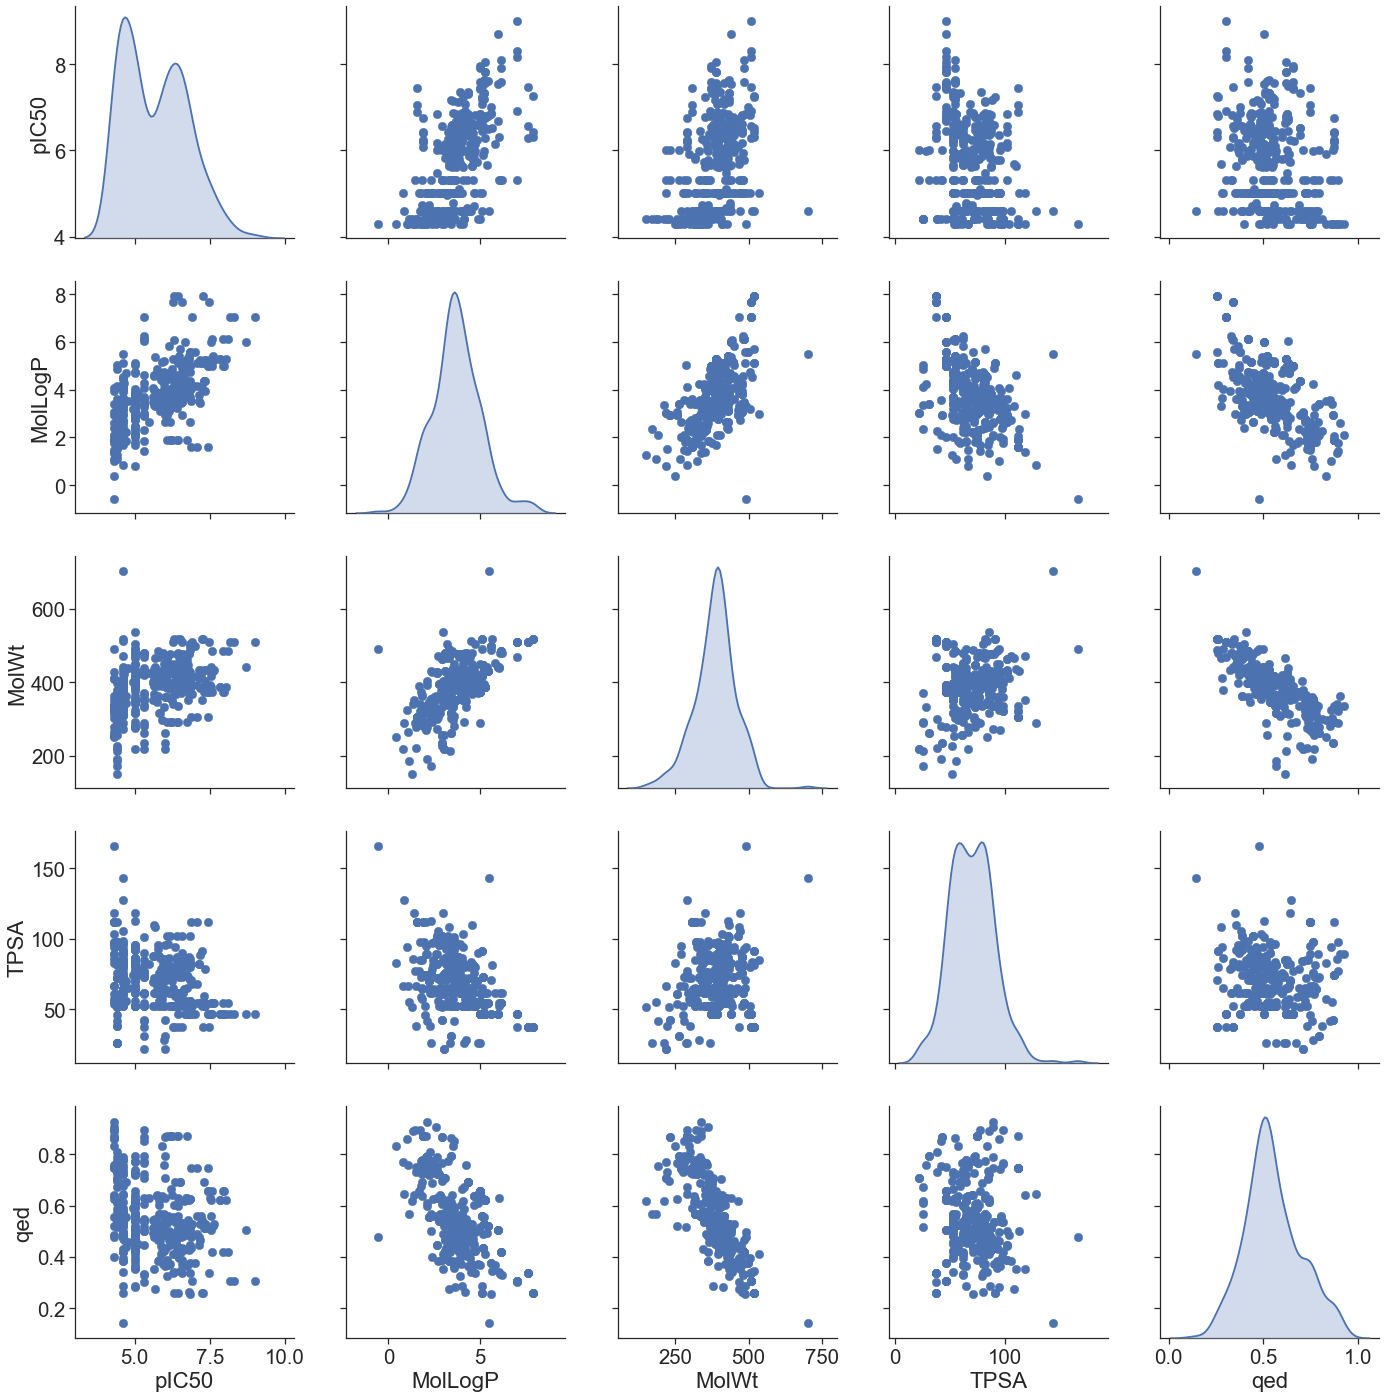

In [16]:
# seaborn -- for better looking plots
import seaborn as sns
sns.set(style="ticks", color_codes=True)
sns.set_context("notebook", font_scale=1.85, rc={"lines.linewidth": 1.85})
#sns.set_context("talk", rc={"lines.linewidth": 2})
sns.color_palette("pastel")

g = sns.pairplot(data[['pIC50', 'MolLogP', 'MolWt', 'TPSA', 'qed']], height=4, diag_kind="kde", markers="o",
                 plot_kws=dict(s=70, edgecolor="b", linewidth=0.5),
                 diag_kws=dict(shade=True))

#g.savefig('EDA.png')

## Training dataset's description

The training dataset contains 50 small organic compounds

----

From the plot and the data summary, displayed above, we notice that there are many compounds with high MW (MW~600) and high Polar Surface Area (TPSA > 100).
I would like to highlight these compounds and then it will be interesting to check how the models's behaviour on these compounds.

There are 2 compounds with high MW (>55) OR TPSA (>125) values!


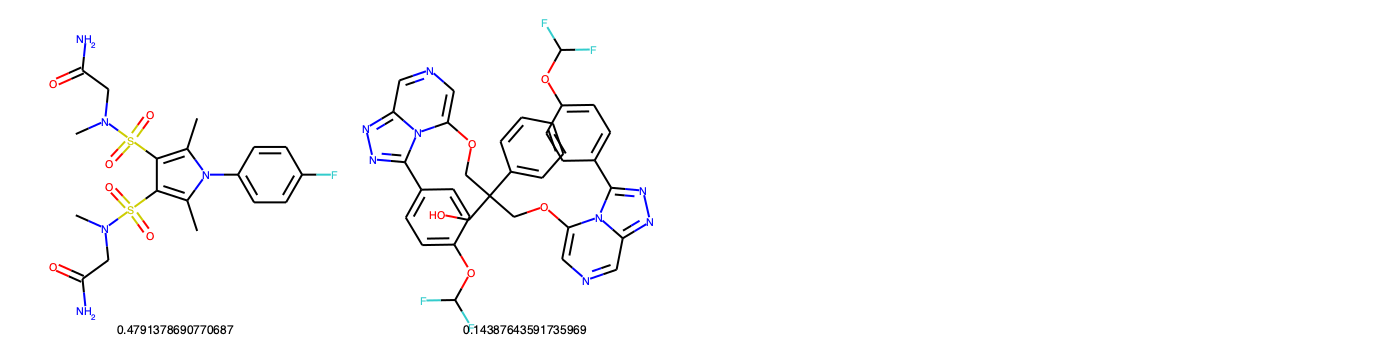

In [20]:
from rdkit.Chem.Draw.MolDrawing import MolDrawing, DrawingOptions #Only needed if modifying defaults
DrawingOptions.bondLineWidth = 1.1
DrawingOptions.atomLabelFontSize = 50
DrawingOptions.dotsPerAngstrom = 100

highMW =  data[(data['MolWt'] > 650) | (data['TPSA'] > 155)]
#highMW.head()
print("There are", len(highMW), "compounds with high MW (>55) OR TPSA (>125) values!")
PandasTools.FrameToGridImage(highMW, molsPerRow=4, subImgSize=(350,350), legendsCol='qed', maxMols=6)

There are indeed some really "interesting" compounds in this dataset.   

-----
## Fingerprints
### Let's generate some (chemical) fingerprints!
We would like to encode the 2D structure of a molecule in a form that a machine learning model could "understand". In this work we will use the fingerprint approach. 

Fingerprints were first used in molecular substructure search: finding a compound with a certain substructure in a molecular database. Fingerprinting creates an efficient representation of the molecular graph. The basic process of fingerprinting is as follows, first the algorithm generates a set of patterns. For instance, enumeration of different paths is common:

For example (taken from Daylight's site), the molecule OC=CN would generate the following patterns:  
0-bond paths:  C / O / N  
1-bond paths:  OC / C=C / CN  
2-bond paths:  OC=C / C=CN  
3-bond paths:  OC=CN  

The length of the fingerprints, generated in this work, is 1024 bits. Each bit helps encode a part of the molecule, such as atom environments along a path with Morgan fingerprints for instance, or number and type of functionalities with MACCS fingerprints.

If the number of bits is reduced in amount we risk two different atom environments being encoded with the same bits. Thus two molecules could be identified as more similar than they actually are. 

More info about chemical fingerprints can be found here [2].

RDKIT (rdkit.org), an open source cheminformatics library, is used for generating the fingerprints.

In [21]:
print("Converting Morgan fingerprints")

# Morgan fingerprints, length 1024 bits
def Morgan_fingerprint(mol):
    fp = np.zeros((1,))
    ConvertToNumpyArray(GetMorganFingerprintAsBitVect(mol, 2, nBits = 1024), fp)
    return fp

data['fp_Morgan'] = data['ROMol'].apply(Morgan_fingerprint)

Converting Morgan fingerprints


I will use the Morgan fingerprint, as they result the lowest mean absolute error regression loss (most of the times...). 
A new data matrix *X* is created and then fed into machine learning models.

In [22]:
st = StandardScaler()
X = np.array(list(data['fp_Morgan']))

X_st = st.fit_transform(X)

print(X.shape)
print(X_st.shape)
#print(X_st[1,:])

(369, 1024)
(369, 1024)


### Splitting data into two different ways for training a Naive Bayes and a RF classification model

In [86]:
# Data split for the NB model
# Cmpds with pxc50 < 7 --> inactive (0)
# Cmpds with pxc50 > 7 --> active (1)

data.loc[data['PXC50'] < 7, 'Cat1'] = 0
data.loc[data['PXC50'] >= 7, 'Cat1'] = 1

y_nb = data['Cat1'].values

# Data split for the RF classification model
# cmpds have been ordered using their activity in ascending order
# First 20% --> active (1)
# Rest of dataset --> inactive (0)
data_sorted = data.sort_values('PXC50', ascending=False)

n = 0.2

data_sorted['Cat2'] = np.arange(len(data_sorted)) < (len(data_sorted) * n)
data_sorted.Cat2 = data_sorted.Cat2.astype(int)

#data_sorted['Cat2'].iloc[-10:]

y_rfc = data_sorted['Cat2'].values

In [27]:
print(np.logspace(-10, -5, 10))

[1.00000000e-10 3.59381366e-10 1.29154967e-09 4.64158883e-09
 1.66810054e-08 5.99484250e-08 2.15443469e-07 7.74263683e-07
 2.78255940e-06 1.00000000e-05]


### ML Gym area
Applying grid search to explore the hyperparameters of the RandomForestRegressor, LightGBMRegressor, GaussianProcessRegressor, and Kernel Ridge models in sklearn.

In [23]:
RFmodel = GridSearchCV(RandomForestRegressor(), cv=20,
                       param_grid={"n_estimators": np.linspace(10, 200, 25).astype('int')},
                       scoring='neg_mean_absolute_error', n_jobs=-1)

RFmodel = RFmodel.fit(X, y)
Best_RandomForestRegressor = RFmodel.best_estimator_

print("Best Random Forest model")
print('Best parameters found by grid search are:', RFmodel.best_params_)
print('Best score:', -1*RFmodel.best_score_)

/Users/btatsis/anaconda3/envs/comptoir/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best Random Forest model
Best parameters found by grid search are: {'n_estimators': 120}
Best score: 0.543702023059879


In [24]:
GPmodel = GridSearchCV(GaussianProcessRegressor(normalize_y=True), cv=20,
                       param_grid={"alpha": np.logspace(-15, -10, 30)}, 
                       scoring='neg_mean_absolute_error', n_jobs=-1)

GPmodel = GPmodel.fit(X, y)
Best_GaussianProcessRegressor = GPmodel.best_estimator_

print("Best Gaussian Process model")
print('Best parameters found by grid search are:', GPmodel.best_params_)
print('Best score:', -1*GPmodel.best_score_)

Best Gaussian Process model
Best parameters found by grid search are: {'alpha': 1.4873521072935117e-15}
Best score: 0.8977927768228827


/Users/btatsis/anaconda3/envs/comptoir/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [25]:
KRmodel = GridSearchCV(KernelRidge(), cv=20,
                       param_grid={"alpha": np.logspace(-10, -5, 10),
                                   "gamma": np.logspace(-12, -9, 10), "kernel" : ['laplacian', 'rbf']}, 
                       scoring='neg_mean_absolute_error', n_jobs=-1)

KRmodel = KRmodel.fit(X, y)
Best_KernelRidge = KRmodel.best_estimator_

print("Best Kernel Ridge model")
print('Best parameters found by grid search are:', KRmodel.best_params_)
print('Best score for Kernel Ridge model: ', -1*KRmodel.best_score_)

Best Kernel Ridge model
Best parameters found by grid search are: {'alpha': 1.2915496650148826e-09, 'gamma': 4.641588833612773e-11, 'kernel': 'laplacian'}
Best score for Kernel Ridge model:  0.565874588097026


/Users/btatsis/anaconda3/envs/comptoir/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [26]:
LGBmodel = GridSearchCV(lgb.LGBMRegressor(), cv=20,
                       param_grid={'boosting_type': ['gbdt'], 
                                   'num_leaves': [10, 20, 30, 50, 75, 100],
                                   'learning_rate': [0.0001, 0.001, 0.01, 0.1]}, 
                        scoring='neg_mean_absolute_error', n_jobs=-1)

LGBmodel = LGBmodel.fit(X, y)
Best_LGBM = LGBmodel.best_estimator_

print("Best Light GBM model")
print('Best parameters found by grid search are:', LGBmodel.best_params_)
print('Best score for Light GBM model: ', -1*LGBmodel.best_score_)

NameError: name 'lgb' is not defined

## Machine Learning models
*Support Vector Regression* will be used as benchmark model and the following machine learning models will be tested:

In [28]:
# alpha_grid = {'alpha': np.logspace(1e-11,1e-1,8)}
# Maybe adding more ML models and some DL

ml_models = {
            #'Linear Regression': LinearRegression(),
            'Kernel Ridge Regression': Best_KernelRidge,
            'Guassian Process Regressor': Best_GaussianProcessRegressor,
            'Support Vector Regression': SVR(gamma='auto', C=1.0, epsilon=0.2),
            #'KNeighborsRegressor': KNeighborsRegressor(),
            #'Neural Network': MLPRegressor(alpha=0.001, max_iter=1000, hidden_layer_sizes=[8,6], early_stopping=True, random_state=prng),
            'NN': MLPRegressor(hidden_layer_sizes=(10, 5,), activation='relu', solver='lbfgs', learning_rate='adaptive', max_iter=1000, learning_rate_init=0.003, alpha=0.01),
            'NN2': MLPRegressor(solver='lbfgs'),   
            'Gradient Boosted Trees': GradientBoostingRegressor(n_estimators=100),
            'Random forest': Best_RandomForestRegressor,
            #'LightGBM': Best_LGBM,
            #'XGBoost': XGBRegressor(n_estimators=500, learning_rate=0.01, gamma=0, subsample=0.75, colsample_bytree=1, max_depth=8)
            }

The following plotting function will be employed to visualize the performance of the machine learning models.
This matplotlib function got so complicated! Is there another way to plot the data?

In [29]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline 

def plot_results(y_pred_train, y_pred_test, y_train, y_test, y_max, y_min, title='', title1='', figsize=(8,6), fontsize=18):   
    
    font = {'family': 'monospace',
        'color':  'darkblue',
        'weight': 'normal',
        'size': fontsize,
        }
    
    plt.clf()
    plt.figure(figsize=figsize)
    plt.ylim(y_min - 0.15, y_max + 0.25)
    plt.xlim(y_min - 0.15, y_max + 0.25)
   
    #plt.ylim(y_min-1, y_max+1)
    #plt.xlim(y_min-1, y_max+1)
    plt.tick_params(axis='both', which='major', labelsize=fontsize-2)
    plt.tick_params(axis='both', which='minor', labelsize=fontsize-3)
    plt.scatter(y_train, y_pred_train, label = 'training set', c='black', marker='o', alpha = 0.6)
    #plt.title(title, fontdict=font)
    plt.title(title, fontsize=fontsize+2)
    plt.xlabel('measured logD', fontsize=fontsize+1)
    plt.ylabel('predicted logD', fontsize=fontsize+1)
    #plt.text(y_min+5, y_max, title2, ha='center', va='center', fontdict=font)
    plt.scatter(y_test, y_pred_test, c='red', label='test set', marker='x')
    # diagonal line
    plt.plot([y_min, y_max], [y_min, y_max], ls="--", c=".3", alpha=0.6)
    plt.legend(loc=4, fontsize=fontsize-2)
    
    plt.savefig(title1 + '.png', bbox_inches='tight')
    plt.show()

### Let's do some ML!

In [30]:
mean_scores = {}
percent_errors = {}

rmses = {}
rmseS = []

r_squares = {}
r_squareS = []

spearmanRs = {}
spearmanRS = []

evss = {}

epochs = 20

for (name, model) in ml_models.items():
    #print(model)
    print("Running %s ..." % name)
    scores = cross_val_score(model, X, y, cv=20, n_jobs=-1, scoring='neg_mean_absolute_error')
    scores = -1*scores
    mean_score = scores.mean()
    mean_scores[name] = mean_score

    for epoch in range(epochs):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        model.fit(X_train, y_train)
            
        y_pred_train = model.predict(X_train)
        y_pred_test  = model.predict(X_test)
        
        # R^2
        r_square = r2_score(y_test, y_pred_test)
        r_squareS.append(r_square)
        
        # Root Mean Square error
        rmse = mean_squared_error(y_test, y_pred_test) ** 0.5
        rmseS.append(rmse)
        
        # Spearman of prediction
        spr = spearmanr(y_test, y_pred_test)
        spearmanRS.append(spr[0])
   
    r_squares[name] = np.array(r_squareS)
    
    rmses[name] = np.array(rmseS)
    
    spearmanRs[name] = np.array(spearmanRS)
    
    #print(mean_scores[name], np.mean(r_squares[name]), np.std(r_squares[name]))
    
# Sorting models dictionary based on R square    
sorted_names = sorted(mean_scores, key=mean_scores.__getitem__, reverse=True)

print("\n----------------------------------")
print("            ML model       &     R^2      &     RMSe     & |CV_error| & Spearman R coefficient  & Explained variance score  &   % test err ")
print("----------------------------------")
for i in range(len(sorted_names)):
    name = sorted_names[i]
    #print("%25s | %5.3f | %5.3f | %5.3f | %5.3f | %5.3f | %5.3f " % (name, r_squares[name], rmses[name], spearmanRs[name], evss[name], percent_errors[name], mean_scores[name]))
    #print("%25s | %5.3f | %5.3f | %5.3f | %5.3f | %5.3f | %5.3f " % (name, np.mean(r_squares[name]), rmses[name], mean_scores[name]))
    print(f"{name:26s} | {np.mean(r_squares[name]):4.2f} +/- {np.std(r_squares[name]):.2f} | {np.mean(rmses[name]):.2f} +/- {np.std(rmses[name]):.2f} | {mean_scores[name]:.2f} | {np.mean(spearmanRs[name]):.2f} +/- {np.std(spearmanRs[name]):.2f}")

Running Kernel Ridge Regression ...
Running Guassian Process Regressor ...
Running Support Vector Regression ...
Running NN ...
Running NN2 ...
Running Gradient Boosted Trees ...
Running Random forest ...

----------------------------------
            ML model       &     R^2      &     RMSe     & |CV_error| & Spearman R coefficient  & Explained variance score  &   % test err 
----------------------------------
Guassian Process Regressor | 0.50 +/- 0.17 | 0.71 +/- 0.12 | 0.89 | 0.78 +/- 0.06
Support Vector Regression  | 0.48 +/- 0.15 | 0.73 +/- 0.10 | 0.71 | 0.76 +/- 0.07
NN                         | 0.50 +/- 0.15 | 0.72 +/- 0.11 | 0.67 | 0.77 +/- 0.07
NN2                        | 0.51 +/- 0.15 | 0.71 +/- 0.10 | 0.62 | 0.78 +/- 0.07
Gradient Boosted Trees     | 0.54 +/- 0.15 | 0.69 +/- 0.10 | 0.59 | 0.79 +/- 0.06
Kernel Ridge Regression    | 0.65 +/- 0.07 | 0.61 +/- 0.06 | 0.57 | 0.81 +/- 0.05
Random forest              | 0.56 +/- 0.15 | 0.67 +/- 0.11 | 0.55 | 0.79 +/- 0.07


### Naive Bayes

In [88]:
gnb = GaussianNB()

accuracy = []

epochs = 10

for epoch in range(epochs):
    X_train, X_test, y_train, y_test = train_test_split(X, y_nb, test_size=0.2)
    gnb.fit(X_train, y_train)
            
    y_pred_train = gnb.predict(X_train)
    y_pred_test  = gnb.predict(X_test)

    print("Accuracy:", accuracy_score(y_test, y_pred_test))

Accuracy: 0.6995708154506438
Accuracy: 0.7682403433476395
Accuracy: 0.7296137339055794
Accuracy: 0.7081545064377682
Accuracy: 0.6952789699570815
Accuracy: 0.7381974248927039
Accuracy: 0.6995708154506438
Accuracy: 0.7553648068669528
Accuracy: 0.6781115879828327
Accuracy: 0.7553648068669528


### Results and  Discussion 

**ML model    **|**R^2  **|** RMSe **|**Spearman R coefficient **|**Explained variance score  **|**% test err   **|**abs error in CV**
:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:
Gradient Boosted Trees | 0.678 | 0.489 | 0.788 | 0.678 | 5.366 | 0.465 
            Random forest | 0.600 | 0.515 | 0.773 | 0.601 | 5.318 | 0.508 
      KNeighborsRegressor | 0.563 | 0.580 | 0.752 | 0.568 | 6.577 | 0.515 
Support Vector Regression | 0.499 | 0.644 | 0.717 | 0.512 | 6.956 | 0.532 

In [87]:
rfc = RandomForestClassifier()

accuracy = []

epochs = 10

for epoch in range(epochs):
    X_train, X_test, y_train, y_test = train_test_split(X, y_rfc, test_size=0.2)
    rfc.fit(X_train, y_train)
            
    y_pred_train = rfc.predict(X_train)
    y_pred_test  = rfc.predict(X_test)

    print("Accuracy:", accuracy_score(y_test, y_pred_test))

/Users/btatsis/anaconda3/envs/comptoir/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy: 0.8497854077253219
Accuracy: 0.8369098712446352
Accuracy: 0.8497854077253219
Accuracy: 0.8412017167381974
Accuracy: 0.8454935622317596
Accuracy: 0.8583690987124464
Accuracy: 0.8626609442060086
Accuracy: 0.871244635193133
Accuracy: 0.8283261802575107
Accuracy: 0.8240343347639485


#### Using Kernel Ridge Regression to predict logD

The data set contains 33 compounds
The data set contains 33 compounds


RDKit ERROR: [17:18:50] Explicit valence for atom # 21 C, 6, is greater than permitted
RDKit ERROR: [17:18:50] Explicit valence for atom # 21 C, 6, is greater than permitted


,OSM Code,SMILES,InChI,InChI Key,Original Qualifier,Experimental (uM),ROMol,pIC50
1,OSM-S-690,FC(F)C1(C2)CC2(COC3=CN=CC4=NN=C(C5=CC=C(OC(F)F)C=C5)N43)C1,"InChI=1S/C19H16F4N4O2/c20-16(21)19-7-18(8-19,9-19)10-28-14-6-24-5-13-25-26-15(27(13)14)11-1-3-12(4-2-11)29-17(22)23/h1-6,16-17H,7-10H2",PXXUWBAUMUWHOT-UHFFFAOYSA-N,-,2.630,"<img src="""" alt=""Mol""/>",5.580044
2,OSM-LO-2,FC(F)OC(C=C1)=CC=C1C2=NN=C3C=NC=C(OCC(CO)C4=C(F)C=CC=C4)N32,"InChI=1S/C21H17F3N4O3/c22-17-4-2-1-3-16(17)14(11-29)12-30-19-10-25-9-18-26-27-20(28(18)19)13-5-7-15(8-6-13)31-21(23)24/h1-10,14,21,29H,11-12H2",ABSBXVNECYEKEY-UHFFFAOYSA-N,-,0.159,"<img src="""" alt=""Mol""/>",6.798603
3,OSM-LO-7,FC(F)OC(C=C1)=CC=C1C2=NN=C3C=NC=C(OCC(CO)C4=C(F)C=C(F)C=C4F)N32,"InChI=1S/C21H15F5N4O3/c22-13-5-15(23)19(16(24)6-13)12(9-31)10-32-18-8-27-7-17-28-29-20(30(17)18)11-1-3-14(4-2-11)33-21(25)26/h1-8,12,21,31H,9-10H2",UTKUNEDKHGJWFZ-UHFFFAOYSA-N,-,0.890,"<img src="""" alt=""Mol""/>",6.050610
4,OSM-LO-8,FC(F)OC(C=C1)=CC=C1C2=NN=C3C=NC=C(OCC(CO)C4=C(F)C=C(F)C(F)=C4)N32,"InChI=1S/C21H15F5N4O3/c22-15-6-17(24)16(23)5-14(15)12(9-31)10-32-19-8-27-7-18-28-29-20(30(18)19)11-1-3-13(4-2-11)33-21(25)26/h1-8,12,21,31H,9-10H2",VNWHTGHTARECMP-UHFFFAOYSA-N,-,0.190,"<img src="""" alt=""Mol""/>",6.721246
5,OSM-LO-6,FC(F)OC(C=C1)=CC=C1C2=NN=C3C=NC=C(OCC(CO)C4=CC(C(F)(F)F)=CC=C4)N32,"InChI=1S/C22H17F5N4O3/c23-21(24)34-17-6-4-13(5-7-17)20-30-29-18-9-28-10-19(31(18)20)33-12-15(11-32)14-2-1-3-16(8-14)22(25,26)27/h1-10,15,21,32H,11-12H2",RSUSOBALBASKRU-UHFFFAOYSA-N,-,0.094,"<img src="""" alt=""Mol""/>",7.026872

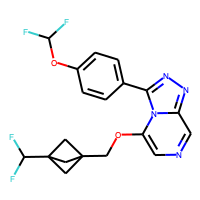
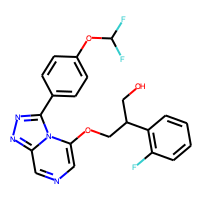
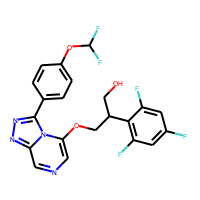
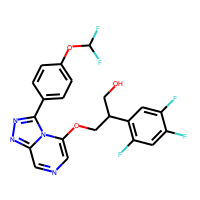
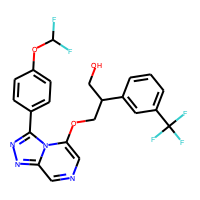

In [52]:
data_pred = pd.read_csv('predictions_Laksh.csv', header=0)

data_pred['Exscientia_predictions'] = data_pred['Exscientia_predictions'].astype(float)

# Target values

data_pred['ROMol'] = data_pred['SMILES'].apply(Chem.MolFromSmiles)

# Remove molecules that could not be parsed from SMILES
data_pred = data_pred[~data_pred.ROMol.isnull()]

data_pred['pIC50'] = calc_pIC50(data_pred['Exscientia_predictions'])

y_pred = data_pred['pIC50'].values
print(f"The data set contains {len(data_pred)} compounds")

data_pred.head(n=3)

data_val = pd.read_csv('validation_set.csv', header=0)
data_val['ROMol'] = data_val['SMILES'].apply(Chem.MolFromSmiles)

data_val = data_val[~data_val.ROMol.isnull()]

data_val['pIC50'] = calc_pIC50(data_val['Experimental (uM)'])

y_val = data_val['pIC50'].values
print(f"The data set contains {len(data_val)} compounds")

data_val.head()

/Users/btatsis/anaconda3/envs/comptoir/lib/python3.6/site-packages/rdkit/Chem/Draw/IPythonConsole.py:183: UserWarning: Truncating the list of molecules to be displayed to 20. Change the maxMols value to display more.
  % (maxMols))


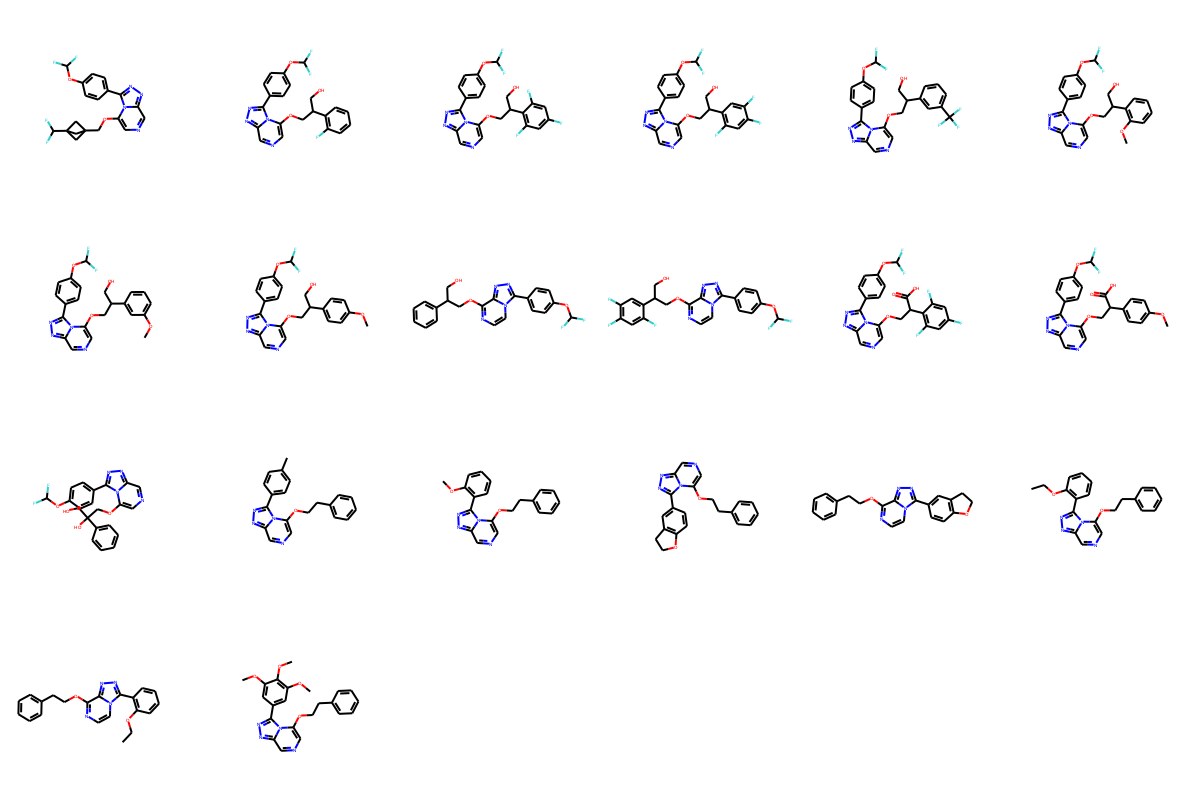

In [37]:
PandasTools.FrameToGridImage(data_pred, molsPerRow=6, legendsCol='', maxMols=20)

(33, 1024) (33,) (369, 1024) (369,)
(33, 1024) (33,) (369, 1024) (369,)
(402, 1024) (402,)
0.14947324797157402


<Figure size 432x288 with 0 Axes>

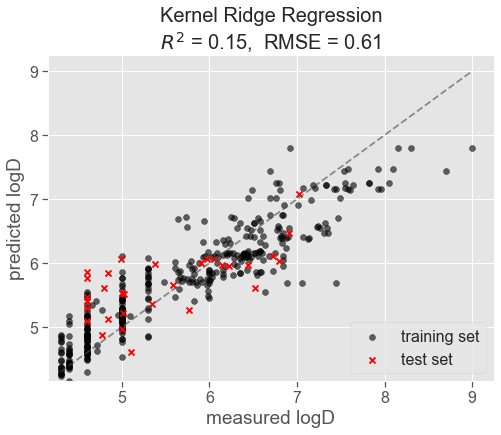

In [54]:
data_pred['fp_Morgan'] = data_pred['ROMol'].apply(Morgan_fingerprint)

X_pred = np.array(list(data_pred['fp_Morgan']))
print(X_pred.shape, y_pred.shape, X.shape, y.shape)

data_val['fp_Morgan'] = data_val['ROMol'].apply(Morgan_fingerprint)

X_val = np.array(list(data_val['fp_Morgan']))
print(X_val.shape, y_val.shape, X.shape, y.shape)

# These two lines are absolutely wrong!
#X_tol = np.concatenate((X, X_pred), axis=0)
#y_tol = np.concatenate((y, y_pred), axis=0)
print(X_tol.shape, y_tol.shape)

Best_KernelRidge.fit(X, y)

with open('b_kr.pkl', 'wb') as f:
    pickle.dump(Best_KernelRidge, f)
          
y_pred_train = Best_KernelRidge.predict(X)
y_pred_pred = Best_KernelRidge.predict(X_pred)

y_pred_val = Best_KernelRidge.predict(X_val)

r_square = r2_score(y_pred, y_pred_pred)
print(r_square)
rmse = mean_squared_error(y_val, y_pred_val) ** 0.5

# Call ploting function
fulltitle = "Kernel Ridge Regression" + "\n" + "$R^{2}$ = " + str("{:.2f}".format(r_square)) + ',  RMSE = ' + str("{:.2f}".format(rmse))
#fulltitle = f"Kernel Ridge Regression \n $R^{2}$ = {r_square:2.f}, RMSE = {rmse:.2f}"
plot_results(y_pred_train, y_pred_val, y, y_val, np.max(y), np.min(y), title=fulltitle, title1=name, figsize=(8,6))

#r_square_2 = r2_score(y_val, data_val['logD_CXN'])
#rmse_2 = mean_squared_error(y_val, data_val['logD_CXN']) ** 0.5#

# Call ploting function
#fulltitle = "ChemAxon" + "\n" + "$R^{2}$ = " + str("{:.2f}".format(r_square_2)) + ',  RMSE = ' + str("{:.2f}".format(rmse_2))
#plot_results(y_pred_train, data_val['logD_CXN'], y, y_val, np.max(y), np.min(y)-1, title=fulltitle, title1=name, figsize=(8,6))

### Fingerprint contributions

In [40]:
mySMILES ='Cc1noc(c1-c1ccc2n(c(nc2c1)[C@@H]1CCC(=O)N1c1ccc(c(c1)F)F)C1CCC(CO)CC1)C'

mols = [None, Chem.MolFromSmiles(mySMILES)]

radius = 2
bit_size = 1024
fps_morgan2 = []
info_morgan2 = []
num_mols = len(mols) - 1
mols = [mols[i+1] for i in range(num_mols)] # remove reference cmp from list
for m in mols:
    info = {}
    fps_morgan2.append(AllChem.GetMorganFingerprintAsBitVect(m, radius, bit_size, bitInfo=info))
    info_morgan2.append(info)
    
mol_weights = []
for i,m in enumerate(mols):
    weights = []
    orig_pp = rf_reg.predict(np.array(fps_morgan2[i]).reshape(1, -1))[0]
    #print(orig_pp)
    # get bits for each atom
    bitmap = [~DataStructs.ExplicitBitVect(1024) for x in range(m.GetNumAtoms())]
    for bit, es in info_morgan2[i].items():
        for at1, rad in es:
            if rad == 0: # for radius 0
                bitmap[at1][bit] = 0
            else: # for radii > 0
                env = Chem.FindAtomEnvironmentOfRadiusN(m, rad, at1)
                amap = {}
                submol = Chem.PathToSubmol(m, env, atomMap=amap)
                for at2 in amap.keys():
                    bitmap[at2][bit] = 0
    # loop over atoms
    for at1 in range(m.GetNumAtoms()):
        new_fp = np.array(fps_morgan2[i] & bitmap[at1]).reshape(1, -1)
        new_pp = rf_reg.predict(new_fp)[0]
        weights.append(orig_pp-new_pp)
    mol_weights.append(weights)

NameError: name 'rf_reg' is not defined

In [41]:
def generateSimilarityMaps(mols, weights, fp):
    '''Generates a similarity map for a set of molecules and weights'''
    # colormap to use
    mycm = cm.PiYG
    # loop over molecules
    for i,m in enumerate(mols):
        fig = Draw.MolToMPL(m, coordScale=1.5, size=(250,250))
        # the values 0.02 and 0.01 can be adjusted for the size of the molecule
        x,y,z = Draw.calcAtomGaussians(m, 0.02, step=0.01, weights=weights[i])
        # use the maximum absolute peak as maximum scale
        maxscale = max(math.fabs(np.min(z)), math.fabs(np.max(z)))
        # this does the coloring
        fig.axes[0].imshow(z, cmap=mycm, interpolation='bilinear', origin='lower', extent=(0,1,0,1), vmin=-maxscale, vmax=maxscale)
        # this draws 10 contour lines
        # alternatively also the z values for the lines can be specified
        fig.axes[0].contour(x, y, z, 10, colors='k', alpha=0.5)
        ax = fig.axes[0]
        ax.set_title('Example') #adds HERG result to title
        # this writes the figure in a file
       # fig.savefig('pics/mol'+str(i+1)+'_'+fp+'.png', bbox_inches='tight') #if generating multiple molecules
        fig.savefig('pics/mol1_rf.png', bbox_inches='tight')

### Similarity maps

IndexError: list index out of range

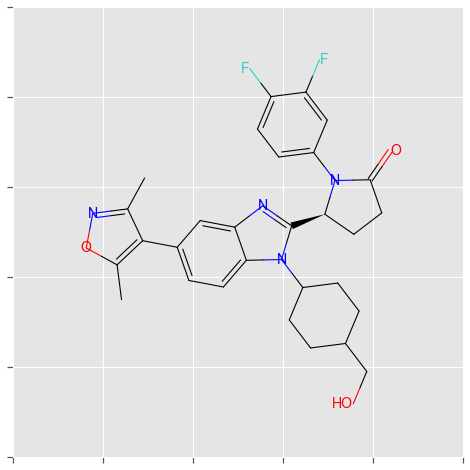

In [42]:
generateSimilarityMaps(mols, mol_weights, 'rf')
from IPython.display import Image
Image('pics/mol1_rf.png')

['Solarize_Light2', '_classic_test', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark-palette', 'seaborn-dark', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'seaborn', 'tableau-colorblind10']


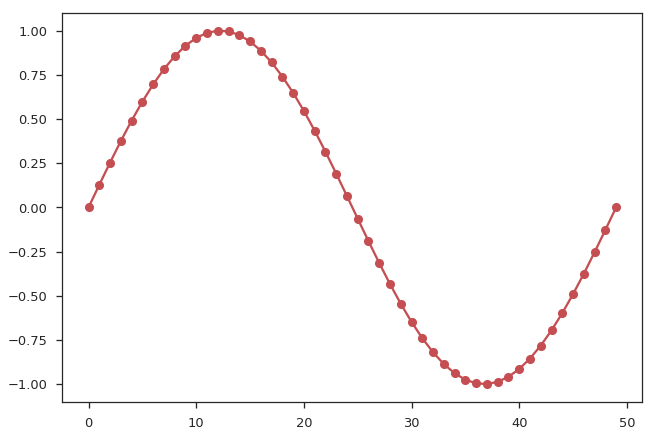

In [67]:
with plt.style.context('seaborn-talk'):
     plt.plot(np.sin(np.linspace(0, 2 * np.pi)), 'r-o')
        
print(plt.style.available)        

Putting PyTorch into the mix!

In [12]:
#Import libraries

import pprint
import argparse
import torch
import torch.optim as optim
from torch import nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
 
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs
import numpy as np

X_train = torch.from_numpy(X[:40])
X_test = torch.from_numpy(X[40:])
Y_train = torch.from_numpy(y[0:40])
Y_test = torch.from_numpy(y[40:])
print(X_train.size(),Y_train.size())
print(X_test.size(), Y_test.size())
 
class QSAR_mlp(nn.Module):
    def __init__(self):
        super(QSAR_mlp, self).__init__()
        self.fc1 = nn.Linear(2048, 524)
        self.fc2 = nn.Linear(524, 10)
        self.fc3 = nn.Linear(10, 10)
        self.fc4 = nn.Linear(10,3)
    def forward(self, x):
        x = x.view(-1, 2048)
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc2(h1))
        h3 = F.relu(self.fc3(h2))
        output = F.sigmoid(self.fc4(h3))
        return output

torch.Size([40, 1024]) torch.Size([40])
torch.Size([14, 1024]) torch.Size([14])


In [16]:
model = QSAR_mlp()
print(model)

epochs = 5 
losses = []
optimizer = optim.Adam( model.parameters(), lr=0.005)
for epoch in range(epochs):
    data, target = Variable(X_train).float(), Variable(Y_train).float()
    print(data.size(), target.size())
    optimizer.zero_grad()
    y_pred = model(data)
    loss = F.cross_entropy(y_pred, target)
    print("Loss: {}".format(loss.data[0]))
    loss.backward()
    optimizer.step()
 
pred_y = model(Variable(X_test).float())
predicted = torch.max(pred_y, 1)[1]
 
for i in range(len(predicted)):
    print("pred:{}, target:{}".format(predicted.data[i], Y_test[i]))
 
print( "Accuracy: {}".format(sum(p==t for p,t in zip(predicted.data, Y_test))/len(Y_test)))

QSAR_mlp(
  (fc1): Linear(in_features=2048, out_features=524, bias=True)
  (fc2): Linear(in_features=524, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=10, bias=True)
  (fc4): Linear(in_features=10, out_features=3, bias=True)
)
torch.Size([40, 1024]) torch.Size([40])


ValueError: Expected input batch_size (20) to match target batch_size (40).

In [51]:
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem.AllChem import  GetMorganFingerprintAsBitVect
import numpy as np
import pickle
import os

# Morgan fingerprints, length 1024 bits
def Morgan_fingerprint(mol):
    fp = np.zeros((1,))
    ConvertToNumpyArray(GetMorganFingerprintAsBitVect(mol, 2, nBits = 1024), fp)
    return fp

X = np.empty((0, 1024))

suppl = Chem.SDMolSupplier('val_set4_cxn.sdf')
for mol in suppl:
    X = np.append(X, [Morgan_fingerprint(mol)], axis=0)

if os.path.exists('b_kr.pkl'):
    with open('b_kr.pkl', 'rb') as pred:
        b_kr = pickle.load(pred)
        
y_pred = []
y_pred = b_kr.predict(X)

print(y_pred, y_pred.shape)

[1.17188835 1.59978104 1.30445671 2.19846153] (4,)
